In [80]:
#import xgboost as xgb

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import sklearn.datasets as ds
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
def draw_confusion_matrix(cm):
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,fmt="d") 
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Data Preparation 

### Load the Data

In [8]:
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')

train_df = shuffle(train_df)
test_df = shuffle(test_df)

X = train_df.iloc[:, :27] 
y = train_df.iloc[:, 27:34]

columns = X.columns
labels = [np.argmax(row) for row in y.values]

In [188]:
np.save('x.npy', X)

np.save('y.npy', labels)

### Train test split

In [203]:
X_train_nsc, X_test_nsc, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [213]:
np.save('X_train_nsc.npy', np.array(X_train_nsc))
np.save('X_test_nsc.npy', np.array(X_test_nsc))
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

### Normalize the data using z-scaler

In [205]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train_nsc)
X_test = sc.transform(X_test_nsc)

/home/gazizullina149/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/gazizullina149/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/gazizullina149/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
labels_train = [np.argmax(row) for row in y_train.values]
labels_test = [np.argmax(row) for row in y_test.values]

### Feature Selection

#### 1. PCA

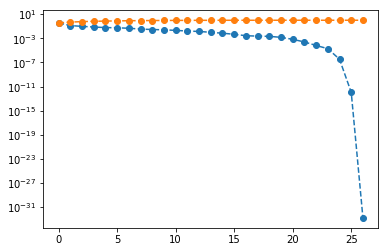

In [12]:
pca_trf = PCA()
pca_trf.fit(X_train)

plt.semilogy(pca_trf.explained_variance_ratio_, '--o')
plt.semilogy(pca_trf.explained_variance_ratio_.cumsum(), '--o')

x - principal components, y-variance
we have to choose number of components from 3 to 6 to be close to 100% of variance

In [13]:
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

/home/gazizullina149/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


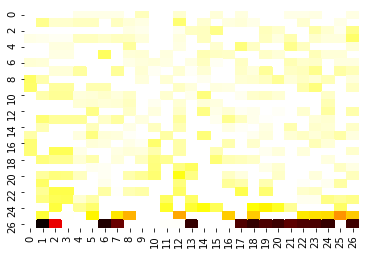

In [14]:
sns.heatmap(np.log(pca_trf.inverse_transform(np.eye(X_train.shape[1]))), cmap="hot", cbar=False)

In [190]:
np.save('X_train_pca.npy', X_train_pca)
np.save('X_test_pca.npy', X_test_pca)

#### 2. Feature Importance

In [23]:
tr_cls = ExtraTreesClassifier()
tr_cls.fit(X_train, y_train)
feature_importances = list(zip(range(0, len(columns)), columns, tr_cls.feature_importances_))
sorted(feature_importances, key=lambda elem: -elem[2])

/home/gazizullina149/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[(10, 'Length_of_Conveyer', 0.074887798289634294),
 (13, 'Steel_Plate_Thickness', 0.064297331532621169),
 (1, 'X_Maximum', 0.049751338848677017),
 (7, 'Sum_of_Luminosity', 0.049120426270919601),
 (0, 'X_Minimum', 0.043878002298930151),
 (8, 'Minimum_of_Luminosity', 0.042436595552835993),
 (4, 'Pixels_Areas', 0.042261764066904378),
 (11, 'TypeOfSteel_A300', 0.041231952131920997),
 (2, 'Y_Minimum', 0.037948091510048777),
 (5, 'X_Perimeter', 0.037691787196978285),
 (23, 'Log_Y_Index', 0.036988111689695659),
 (9, 'Maximum_of_Luminosity', 0.036582183507401653),
 (14, 'Edges_Index', 0.035383544665474824),
 (12, 'TypeOfSteel_A400', 0.035175676218910386),
 (25, 'Luminosity_Index', 0.033739427390742024),
 (16, 'Square_Index', 0.033265925080773286),
 (22, 'Log_X_Index', 0.032647585865147273),
 (24, 'Orientation_Index', 0.032294225834926943),
 (15, 'Empty_Index', 0.032077498076474323),
 (6, 'Y_Perimeter', 0.032039493424658574),
 (21, 'LogOfAreas', 0.03001218514789571),
 (18, 'Edges_X_Index', 0.02

#### 3. Recursive Feature Elimination

fit on logistic regression, likely poorly fit the distribution

In [41]:
params = {'max_depth': 4, 'eta':1, 'silent':1, 'objective':'multi:softprob', 'num_class': 7, 'early_stopping_rounds':60}
epochs = 10
num_features = 10

#svm = SVC(C=1e-3, gamma=1e-1, kernel='rbf')
clf = LogisticRegression(multi_class='ovr', solver='lbfgs')
rfe = RFE(clf, num_features)
rfe = rfe.fit(X_train, labels_train)

print("Num Features: {:d}".format(rfe.n_features_))
selected_features = sorted(list(zip(rfe.support_, rfe.ranking_, columns)), key=lambda elem: elem[1])
#bst = xgb.train(params, X_train, epochs) 
#preds = bst.predict(y_train)

Num Features: 10


In [42]:
selected_features

[(True, 1, 'X_Maximum'),
 (True, 1, 'Sum_of_Luminosity'),
 (True, 1, 'Length_of_Conveyer'),
 (True, 1, 'TypeOfSteel_A400'),
 (True, 1, 'Steel_Plate_Thickness'),
 (True, 1, 'Square_Index'),
 (True, 1, 'Edges_X_Index'),
 (True, 1, 'LogOfAreas'),
 (True, 1, 'Log_X_Index'),
 (True, 1, 'Orientation_Index'),
 (False, 2, 'TypeOfSteel_A300'),
 (False, 3, 'Log_Y_Index'),
 (False, 4, 'Edges_Y_Index'),
 (False, 5, 'Y_Perimeter'),
 (False, 6, 'Maximum_of_Luminosity'),
 (False, 7, 'Minimum_of_Luminosity'),
 (False, 8, 'Y_Maximum'),
 (False, 9, 'Edges_Index'),
 (False, 10, 'Empty_Index'),
 (False, 11, 'X_Perimeter'),
 (False, 12, 'X_Minimum'),
 (False, 13, 'Pixels_Areas'),
 (False, 14, 'Outside_Global_Index'),
 (False, 15, 'Y_Minimum'),
 (False, 16, 'Luminosity_Index'),
 (False, 17, 'Outside_X_Index'),
 (False, 18, 'SigmoidOfAreas')]

random forests are more suitable for the problem so

use rfe with the random forests with the purporse to tackle the problem of random forests to not being able to identify strong predictors due to strong correlation between predictors

In [27]:
class RandomForestClassifierWithCoef(RandomForestClassifier):
    def fit(self, *args, **kwargs):
        super(RandomForestClassifierWithCoef, self).fit(*args, **kwargs)
        self.coef_ = self.feature_importances_
        
rf = RandomForestClassifierWithCoef(n_estimators=500, min_samples_leaf=5, n_jobs=-1)
rfecv = RFE(estimator=rf, verbose=2)
selector=rfecv.fit(X_train, labels_train)

Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.


In [45]:
print("Num Features: {:d}".format(selector.n_features_))
selected_features = sorted(list(zip(selector.support_, selector.ranking_, columns)), key=lambda elem: elem[1])
selected_features

Num Features: 13


[(True, 1, 'X_Minimum'),
 (True, 1, 'X_Maximum'),
 (True, 1, 'Pixels_Areas'),
 (True, 1, 'Sum_of_Luminosity'),
 (True, 1, 'Minimum_of_Luminosity'),
 (True, 1, 'Length_of_Conveyer'),
 (True, 1, 'Steel_Plate_Thickness'),
 (True, 1, 'Square_Index'),
 (True, 1, 'Outside_X_Index'),
 (True, 1, 'LogOfAreas'),
 (True, 1, 'Log_X_Index'),
 (True, 1, 'Orientation_Index'),
 (True, 1, 'Luminosity_Index'),
 (False, 2, 'TypeOfSteel_A300'),
 (False, 3, 'Y_Minimum'),
 (False, 4, 'X_Perimeter'),
 (False, 5, 'Empty_Index'),
 (False, 6, 'Maximum_of_Luminosity'),
 (False, 7, 'Edges_Y_Index'),
 (False, 8, 'Edges_Index'),
 (False, 9, 'TypeOfSteel_A400'),
 (False, 10, 'Edges_X_Index'),
 (False, 11, 'Y_Maximum'),
 (False, 12, 'SigmoidOfAreas'),
 (False, 13, 'Log_Y_Index'),
 (False, 14, 'Y_Perimeter'),
 (False, 15, 'Outside_Global_Index')]

In [50]:
rfe_features = sorted(list(zip(selector.support_, range(0, len(columns)), selector.ranking_, columns)), key=lambda elem: elem[2])
rfe_features = [l[1] for l in rfe_features if l[0]==True ]

In [209]:
X_train_rfe = X_train[:, rfe_features]
X_test_rfe = X_test[:, rfe_features]

In [197]:
np.save('X_train_rfe.npy', X_train_rfe)
np.save('X_test_rfe.npy', X_test_rfe)

In [212]:
X_train_rfe_nsc = np.array(X_train_nsc)[:, rfe_features]
X_test_rfe_nsc = np.array(X_test_nsc)[:, rfe_features]
np.save('X_train_rfe_nsc.npy', X_train_rfe_nsc)
np.save('X_test_rfe_nsc.npy', X_test_rfe_nsc)

#### 4. DBSCAN

plot k distances graph for all the features to select the optimal eps for the DBSCAN

/home/gazizullina149/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


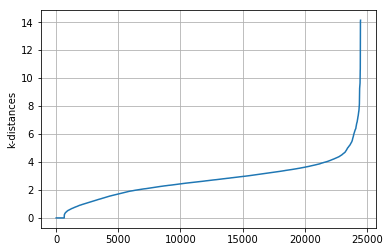

In [64]:
def k_distances2(x, k):
    dim0 = x.shape[0]
    dim1 = x.shape[1]
    p=-2*x.dot(x.T)+np.sum(x**2, axis=1).T+ np.repeat(np.sum(x**2, axis=1),dim0,axis=0).reshape(dim0,dim0)
    p = np.sqrt(p)
    p.sort(axis=1)
    p=p[:,:k]
    pm= p.flatten()
    pm= np.sort(pm)
    return p, pm
m, m2= k_distances2(X_train, 27)
plt.plot(m2)
plt.ylabel("k-distances")
plt.grid(True)
plt.show()

select eps in the are of the greatest inflection (4, 6)

In [136]:
for eps in range(3, 7):
    dbscan = DBSCAN(eps=eps, min_samples=4)
    model = dbscan.fit(X_train)
    labels = model.labels_
    core_samples = np.zeros_like(labels, dtype=bool)

    core_samples[dbscan.core_sample_indices_] = True

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print('[EPS] {}'.format(eps))
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: {}, {}%'.format(n_noise_, int(n_noise_*100/X_train.shape[0])))
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_train, labels))
    print("Completeness: %0.3f" % metrics.completeness_score(labels_train, labels))
    print("V-measure: %0.3f" % metrics.v_measure_score(labels_train, labels))
    print("Adjusted Rand Index: %0.3f"
          % metrics.adjusted_rand_score(labels_train, labels))
    print("Adjusted Mutual Information: %0.3f"
          % metrics.adjusted_mutual_info_score(labels_train, labels, average_method='arithmetic'))
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X_train, labels))
    print('\n')


[EPS] 3
Estimated number of clusters: 7
Estimated number of noise points: 67, 7%
Homogeneity: 0.319
Completeness: 0.381
V-measure: 0.347
Adjusted Rand Index: 0.188
Adjusted Mutual Information: 0.337
Silhouette Coefficient: 0.171


[EPS] 4
Estimated number of clusters: 3
Estimated number of noise points: 18, 1%
Homogeneity: 0.012
Completeness: 0.103
V-measure: 0.021
Adjusted Rand Index: -0.012
Adjusted Mutual Information: 0.011
Silhouette Coefficient: 0.255


[EPS] 5
Estimated number of clusters: 1
Estimated number of noise points: 7, 0%
Homogeneity: 0.003
Completeness: 0.106
V-measure: 0.006
Adjusted Rand Index: -0.003
Adjusted Mutual Information: 0.002
Silhouette Coefficient: 0.427


[EPS] 6
Estimated number of clusters: 1
Estimated number of noise points: 3, 0%
Homogeneity: 0.002
Completeness: 0.159
V-measure: 0.004
Adjusted Rand Index: -0.002
Adjusted Mutual Information: 0.001
Silhouette Coefficient: 0.482




so we select eps=3 or 4

In [163]:
dbscan = DBSCAN(eps=4, min_samples=4)
model = dbscan.fit(X_train)
labels = model.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
centers = np.zeros((n_clusters_, X_train.shape[1]))
for i in range(0, n_clusters_):
    cluster_points = X_train[labels == i]
    cluster_mean = np.mean(cluster_points, axis=0)
    centers[i, :] = cluster_mean

put each cluster center as a feature to the point from that cluster

In [199]:
b = np.zeros_like(X_train)
X_train_dbscan = np.concatenate((X_train, b), axis=1)
b = np.zeros_like(X_test)
X_test_dbscan = np.concatenate((X_test, b), axis=1)

In [200]:
for i in range(0, centers.shape[0]):
    X_train_dbscan[:5, 27:] = centers[i, :]
    X_test_dbscan[:5, 27:] = centers[i, :]

In [201]:
np.save('X_train_dbscan.npy', X_train_dbscan)
np.save('X_test_dbscan.npy', X_test_dbscan)

In [206]:
b = np.zeros_like(X_train)
X_train_dbscan_nsc = np.concatenate((X_train_nsc, b), axis=1)
b = np.zeros_like(X_test)
X_test_dbscan_nsc = np.concatenate((X_test_nsc, b), axis=1)
for i in range(0, centers.shape[0]):
    X_train_dbscan[:5, 27:] = centers[i, :]
    X_test_dbscan[:5, 27:] = centers[i, :]
np.save('X_train_dbscan_nsc.npy', X_train_dbscan_nsc)
np.save('X_test_dbscan_nsc.npy', X_test_dbscan_nsc)

add new features to the test data

In [214]:
b = np.zeros_like(test_df)
test_dbscan_nsc = np.concatenate((test_df, b), axis=1)
np.save('test_dbscan_nsc.npy', X_test_dbscan_nsc)